This notebook illustrates the motion of an electron in spatially dependent magnetic and electric fields perpendicular to each other. This uses the Buneman pusher to evolve particle's equation of motion. See Pg. 58, 59 of Birdsall & Langdon, 1992

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import os

In [2]:
#parameters in cgs units
m = 9.1e-27 #electron's mass in CGS units (gram)
e = 5.e-10 #electron's charge in CGS units (esu) 
qbym = -e/m #electron's charge to mass ratio 
c = 3.e10 #speed of light

fields same as in Fig. 1 of Qin+ paper https://ui.adsabs.harvard.edu/abs/2013PhPl...20h4503Q/abstract

${\bf B} = \sqrt{x^2+y^2} {\bf \hat{z}}$ 

$\phi = \frac{0.01}{\sqrt{x^2+y^2}}$

${\bf E} = -{\bf \nabla} \phi$

A constant electric field (or a constant force in general) perpendicular to a constant magnetic field, causes a drift perpendicular to both ${\bf E}$ and ${\bf B}$, ${\bf u_\perp} = \frac{c({\bf E} \times {\bf B})}{B^2} \left ( \frac{c({\bf F} \times {\bf B})}{qB^2} {\rm~for~a~general~force}\right)$. While E cross B drift is independent of the charge, for a general force electrons and protons drift in the opposite directions leading to currents perpendicular to B.

In [3]:
#fields same as in Fig. 1 of Qin+ paper https://ui.adsabs.harvard.edu/abs/2013PhPl...20h4503Q/abstract
def cal_E_par(x): 
    return 0.0

def cal_E_perp(x):
    return 0.01*np.array([x[0],x[1]])/(x[0]*x[0]+x[1]*x[1])**1.5

def cal_B(x):
    return (x[0]*x[0]+x[1]*x[1])**0.5

In [4]:
#initial conditions not explicitly stated in the paper; following arrived from a lot guessing; remember drift formulae are valid in asymptotic limit only
xi, yi, zi = 5., 0., 0. #initial coordinates
E_perp = np.sqrt(np.sum(cal_E_perp([xi, yi, zi])**2)) #magnitude of Eperp
B = cal_B([xi, yi, zi]) #get value of B at particle position
w_c0 = e*B/(m*c) #local cyclotron angular frequency; doesnt have sign
v_EB_D = c*E_perp/B #magnitude of ExB drift
v_perp = np.abs(qbym*E_perp*0.25*2*np.pi/w_c0) #not the true value, just an estimate! particle accelerates for T_cyc/4 because of Larmor motion
v_mugradB_D = 0.5*v_perp*v_perp/(w_c0*np.sqrt(xi*xi+yi*yi+zi*zi)) #estimate of mu gradB velocity
print("Larmor radius = ", v_perp/w_c0) 
print("E cross B drift velocity = ", v_EB_D/c) 
print("grad B drift in units of c = ", v_mugradB_D/c)
print("v/c perpendicular to B = ", v_perp/c) #print out some useful parameters
print("Larmor period = ", 2.*np.pi/w_c0)
print("Time period of drift circle", 2.*np.pi*np.sqrt(xi*xi+yi*yi+zi*zi)/v_EB_D) #print out some more useful parameters
n_dump = 100000 #number of time dumps of x, v of the particle
vxi, vyi, vzi = 0., 0., 0. #initial velocities

Larmor radius =  0.41167430132640653
E cross B drift velocity =  8e-05
grad B drift in units of c =  5.173251842874999e-06
v/c perpendicular to B =  0.00012566370614359174
Larmor period =  6.861238355440109e-07
Time period of drift circle 1.308996938995747e-05


In [5]:
tend = 5000*2.0*np.pi/w_c0 #evolve for 5000 Larmor orbits

In [6]:
def push_particles(xp, vp, acc_loc, dt): #xp, vp, acc_loc are vectors
    vp += dt*acc_loc #updated velocity
    xp += dt*vp #updated position
    return

def push_only_xp(xp, vp, dt): #update only xp for time dt, given vp 
    xp += dt*vp #updated position
    return

def push_only_vp(vp, acc_loc, dt): #update only vp for time dt, given acceleration
    vp += dt*acc_loc
    return

In [7]:
#initialize coordinates
xp = np.array([xi, yi, zi])
vp = np.array([vxi, vyi, vzi])
E_perp = cal_E_perp(xp)
E_par = cal_E_par(xp)
B = cal_B(xp)
#first offset velocity by -dt/2 to use Leapfrog
acc_loc = qbym*np.array([E_perp[0]+vp[1]*B/c, E_perp[1]-vp[0]*B/c, E_par])
dt = 0.05*2*np.pi/w_c0 #1/20th of a cyclotron orbit
time = 0
data_t = []
data_t.append(np.append(xp,vp)) #appends to the list; list to hold 6 coordinates at each time
push_only_vp(vp, acc_loc, -0.5*dt) #offset velocity by -dt/2 to start Leap-frog; Qin+ 2013 also uses this!

In [8]:
while (time < tend):
    dt = min(dt, tend-time)
    time += dt
    #push velocity
    #step 1; go E cross B drift frame (assumes B != 0)
    vp_minus_x = vp[0] - c*E_perp[1]/B 
    vp_minus_y = vp[1] + c*E_perp[0]/B
    w_c = qbym*B/c
    #gyro-rotation around a given B
    vp_plus_x = np.cos(w_c*dt)*vp_minus_x + np.sin(w_c*dt)*vp_minus_y
    vp_plus_y = -np.sin(w_c*dt)*vp_minus_x + np.cos(w_c*dt)*vp_minus_y
    #apply parallel electic force
    vp_plus_z = vp[2] + qbym*E_par*dt
    #come back to lab frame with negative E cross B drift
    vp_plus_x += c*E_perp[1]/B
    vp_plus_y -= c*E_perp[0]/B
    vp = np.array([vp_plus_x, vp_plus_y, vp_plus_z])
    #push x
    push_only_xp(xp, vp, dt)
    #for output purposes again align x, v at same time; push velocity by dt/2
    v_out = 1.*vp
    E_perp = cal_E_perp(xp)
    E_par = cal_E_par(xp)
    B = cal_B(xp)
    acc_loc = qbym*np.array([E_perp[0]+vp[1]*B/c, E_perp[1]-vp[0]*B/c, E_par])
    push_only_vp(v_out, acc_loc, 0.5*dt) #offset velocity by dt/2 for output
    if (time != tend):
        data_t.append(np.append(xp, v_out))

In [9]:
dt = 0.05*2*np.pi/w_c0 #1/20th of a cyclotron orbit; necessary here because dt is set to a tiny value in the last step of above loop 
t = np.arange(0, time, dt)

Text(0.5, 1.0, 'late time radius')

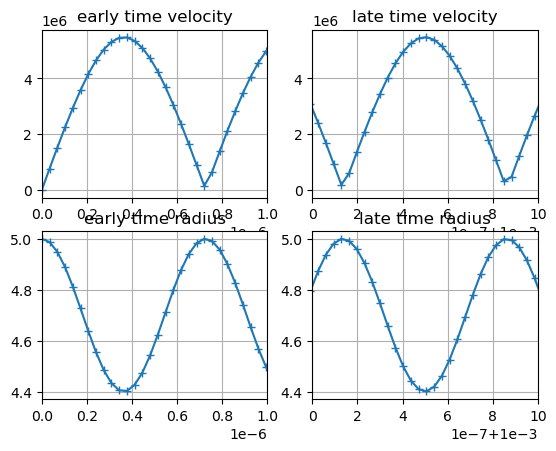

In [10]:
data_t = np.array(data_t)
plt.subplot(221)
plt.plot(t, np.sqrt(data_t[:-1,3]**2+data_t[:-1,4]**2),'-+')
plt.grid()
plt.xlim([0, 1e-6])
plt.title("early time velocity")
plt.subplot(222)
plt.plot(t, np.sqrt(data_t[:-1,3]**2+data_t[:-1,4]**2),'-+')
plt.xlim([0.001, 0.001+1e-6])
plt.grid()
plt.title("late time velocity")
plt.subplot(223)
plt.plot(t, np.sqrt(data_t[:-1,0]**2+data_t[:-1,1]**2),'-+')
plt.grid()
plt.xlim([0, 1e-6])
plt.title("early time radius")
plt.subplot(224)
plt.plot(t, np.sqrt(data_t[:-1,0]**2+data_t[:-1,1]**2),'-+')
plt.xlim([0.001, 0.001+1e-6])
plt.grid()
plt.title("late time radius")

Text(0, 0.5, 'y')

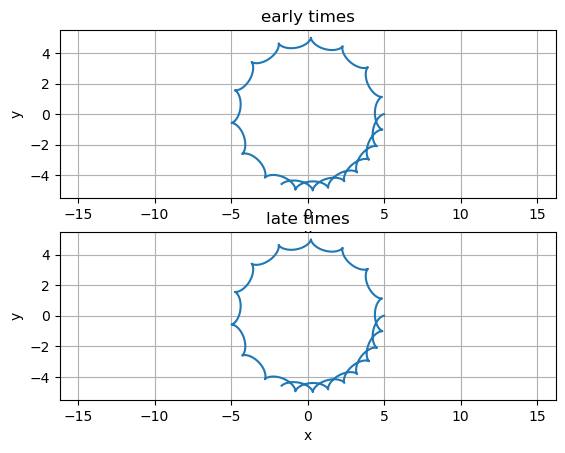

In [11]:
#early time
plt.subplot(211)
plt.plot(data_t[:400,0], data_t[:400,1]) #show evolution for short times
plt.axis('equal')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title("early times")
plt.subplot(212)
plt.plot(data_t[:400,0], data_t[:400,1]) #show evolution for short times
plt.axis('equal')
plt.title("late times")
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

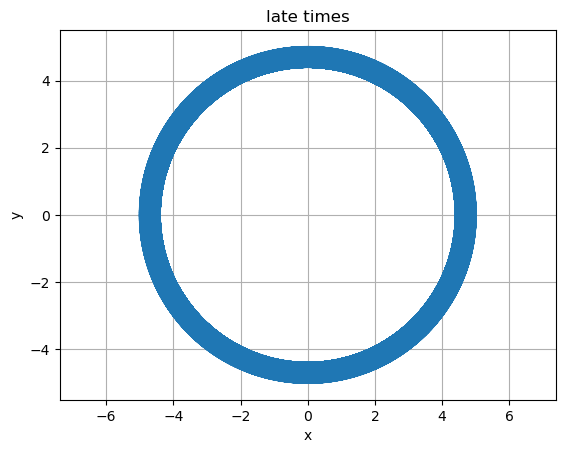

In [12]:
plt.plot(data_t[:,0], data_t[:,1]) #full evolution
plt.axis('equal')
plt.title("late times")
plt.grid()
plt.xlabel('x')
plt.ylabel('y')